# 🛠 Exercises

1. Write a function to visualize an image from any dataset (train or test file) and any class (e.g. "steak", "pizza"... etc), visualize it and make a prediction on it using a trained model.

2. Use feature-extraction to train a transfer learning model on 10% of the Food Vision data for 10 epochs using `tf.keras.applications.efficientnet_v2.EfficientNetV2B0` as the base model. Use the `ModelCheckpoint` callback to save the weights to file.

3. Fine-tune the last 20 layers of the base model you trained in 2 for another 10 epochs. How did it go?

4. Fine-tune the last 30 layers of the base model you trained in 2 for another 10 epochs. How did it go?

In [1]:
# Import helper functions we're going to use in this notebook
from helper_functions import plot_loss_curves, walk_through_dir

In [2]:
# Check out how many images and subdirectories are in our dataset
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test

In [3]:
# Create training and test directories
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [4]:
import tensorflow as tf
tf.__version__

'2.16.2'

In [5]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical",
                                                                            batch_size=BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                image_size=IMG_SIZE,
                                                                label_mode="categorical",
                                                                batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.


2025-01-08 17:12:57.726894: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2025-01-08 17:12:57.726932: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-01-08 17:12:57.726940: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-01-08 17:12:57.726962: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-08 17:12:57.726976: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 2500 files belonging to 10 classes.


In [6]:
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

### 2. Use feature-extraction to train a transfer learning model on 10% of the Food Vision data for 10 epochs using tf.keras.applications.efficientnet_v2.EfficientNetV2B0 as the base model. Use the ModelCheckpoint callback to save the weights to file.

#### Creating a ModelCheckpoint callback

In [7]:
# Set checkpoint path
checkpoint_path = "ten_percent_model_checkpoints_weights_exercises/checkpoint.weights.h5"

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=False,
                                                         save_freq="epoch", # save every epoch
                                                         verbose=1)


#### Building a transfer learning feature extraction model using the Keras Functional API

In [8]:
# Create base model with tf.keras.applications
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False) # We want to use our own dense layer on the top (outputs)

# 2. Freeze the base model (so the underlying pre-trained patterns aren't updated during training)
base_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 4. If using a model like ResNet50V2 you will need to normalize inputs (you don't have to for EfficientNet(s))
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model
x = base_model(inputs)

print(f"Shape after passing inputs through base model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile for the model
model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# 10. Fit the model and save its history
history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs=10,
                                 steps_per_epoch=len(train_data_10_percent),
                                 validation_data=test_data,
                                 validation_steps=int(len(test_data)),
                                 callbacks=[checkpoint_callback])

Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)
Epoch 1/10


2025-01-08 17:13:06.154957: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - accuracy: 0.2565 - loss: 2.1230
Epoch 1: saving model to ten_percent_model_checkpoints_weights_exercises/checkpoint.weights.h5
24/24 ━━━━━━━━━━━━━━━━━━━━ 32s 878ms/step - accuracy: 0.2624 - loss: 2.1138 - val_accuracy: 0.7476 - val_loss: 1.3351
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.7462 - loss: 1.2338
Epoch 2: saving model to ten_percent_model_checkpoints_weights_exercises/checkpoint.weights.h5
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 453ms/step - accuracy: 0.7466 - loss: 1.2303 - val_accuracy: 0.8260 - val_loss: 0.8981
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.8223 - loss: 0.8458
Epoch 3: saving model to ten_percent_model_checkpoints_weights_exercises/checkpoint.weights.h5
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 433ms/step - accuracy: 0.8219 - loss: 0.8460 - val_accuracy: 0.8432 - val_loss: 0.7203
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.8472 - loss: 0.7001
Epoch 4: saving model to ten

### 1. Write a function to visualize an image from any dataset (train or test file) and any class (e.g. "steak", "pizza"... etc), visualize it and make a prediction on it using a trained model.

In [9]:
# Let's visualize our images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import numpy as np
import os

In [10]:
class_names = train_data_10_percent.class_names

In [11]:

# Creating a function that would grab the image from a dataset, visualize and gives the prediction of it. 

def dataset_visualizer(dataset , model):
  '''
  Arguments: 
    dataset --> `tf.data.Dataset` object with (image , label) tuples 
    model --> the trained model 

  Returns: 
    Visualizae the image from the dataset and the prediction class of the image. 
  '''
  image_batch , label_batch = dataset.as_numpy_iterator().next() 
  batch_prob = [model.predict(tf.expand_dims(img , axis = 0)) for img in image_batch]
  batch_preds = [class_names[np.argmax(prob)] for prob in batch_prob]

  plt.figure(figsize= (10 , 10))
  for i in range(4):
    ax = plt.subplot(2 , 2 , i + 1)
    if class_names[np.argmax(label_batch[i])] == batch_preds[i]:
      title_color = 'g'
    else:
      title_color = 'r'
    plt.imshow(image_batch[i].astype('uint8'))
    plt.title(f"actual: {class_names[np.argmax(label_batch[i])]}, pred: {batch_preds[i]}, prob: {batch_prob[i].max():.2f}" , c = title_color)
    plt.axis('off')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━

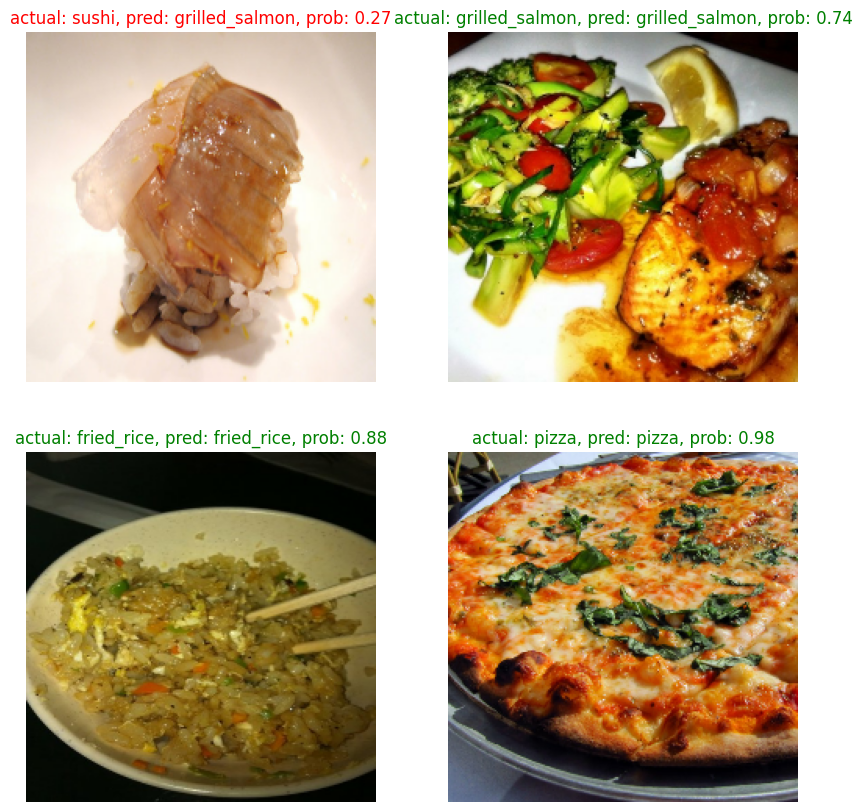

In [17]:
dataset_visualizer(test_data , model_0)

### 4. Fine-tune the last 30 layers of the base model you trained in 2 for another 10 epochs. How did it go?

In [18]:
initial_epochs = 10

In [19]:
model_0.layers

[<InputLayer name=input_layer, built=True>,
 <Functional name=efficientnetv2-b0, built=True>,
 <GlobalAveragePooling2D name=global_average_pooling_layer, built=True>,
 <Dense name=output_layer, built=True>]

In [21]:
# Are these layers trainable?
for layer in model_0.layers:
    print(layer, layer.trainable)

<InputLayer name=input_layer, built=True> True
<Functional name=efficientnetv2-b0, built=True> False
<GlobalAveragePooling2D name=global_average_pooling_layer, built=True> True
<Dense name=output_layer, built=True> True


In [22]:
# What layers are in our base_model (EfficientNetB0) and are they trainable?
for i, layer in enumerate(model_0.layers[1].layers):
    print(i, layer.name, layer.trainable)

0 input_layer False
1 rescaling False
2 normalization False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 

In [23]:
# How many trainable variables are in our base model?
print(len(model_0.layers[1].trainable_variables))

0


In [24]:
# To begin fine-tuning, let's start by setting the last 30 layers of our base_model.trainable = True
base_model.trainable = True

# Freeze all layers except for the last 30
for layer in base_model.layers[:-30]:
    layer.trainable = False

# Recompile (We have to recompile our models every time we make a change)
model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # when fine-tuning you typically want to lower the learning rate by 10x*
                metrics=["accuracy"])

In [25]:
# Check which layers are tunable (trainable)
for layer_number, layer in enumerate(model_0.layers[1].layers):
    print(layer_number, layer.name, layer.trainable)

0 input_layer False
1 rescaling False
2 normalization False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 

In [26]:
# Now we've unfrozen some of the layers closer to the top, how many trainable variables are there?
print(len(model_0.trainable_variables))

28


In [27]:
# Fine tune for another 10 epochs
fine_tune_epochs = initial_epochs + 10

# Refit the model (same as model_2 except with more trainable layers)
history_fine_10_percent_data = model_0.fit(train_data_10_percent,
                                               epochs=fine_tune_epochs,
                                               validation_data=test_data,
                                               validation_steps=int(len(test_data)),
                                               initial_epoch=history_10_percent.epoch[-1], # start training from previous last epoch
                                                )

Epoch 10/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.8729 - loss: 0.5407 - val_accuracy: 0.8632 - val_loss: 0.5218
Epoch 11/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 14s 578ms/step - accuracy: 0.9204 - loss: 0.4383 - val_accuracy: 0.8732 - val_loss: 0.4914
Epoch 12/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 12s 516ms/step - accuracy: 0.9381 - loss: 0.3744 - val_accuracy: 0.8768 - val_loss: 0.4525
Epoch 13/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 12s 519ms/step - accuracy: 0.9385 - loss: 0.3253 - val_accuracy: 0.8820 - val_loss: 0.4303
Epoch 14/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 476ms/step - accuracy: 0.9720 - loss: 0.2642 - val_accuracy: 0.8840 - val_loss: 0.4121
Epoch 15/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 12s 508ms/step - accuracy: 0.9610 - loss: 0.2544 - val_accuracy: 0.8860 - val_loss: 0.3981
Epoch 16/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 12s 496ms/step - accuracy: 0.9718 - loss: 0.2132 - val_accuracy: 0.8880 - val_loss: 0.3908
Epoch 17/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 485ms/step - accuracy: 0.9688 - loss: 0.1846 - val

In [28]:
result_fine_tune_10_percent_last_20 = model_0.evaluate(test_data)
result_fine_tune_10_percent_last_20

79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 91ms/step - accuracy: 0.8822 - loss: 0.3788


[0.35361090302467346, 0.8888000249862671]

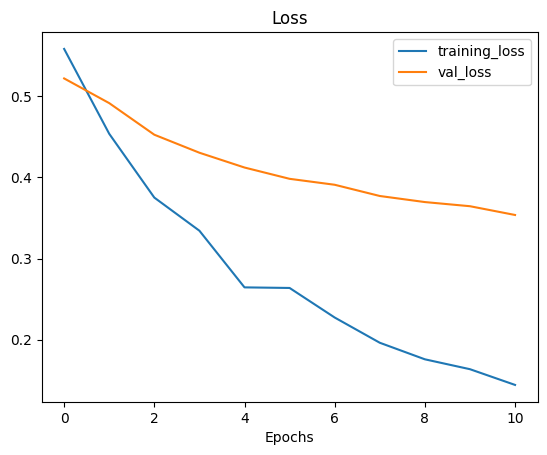

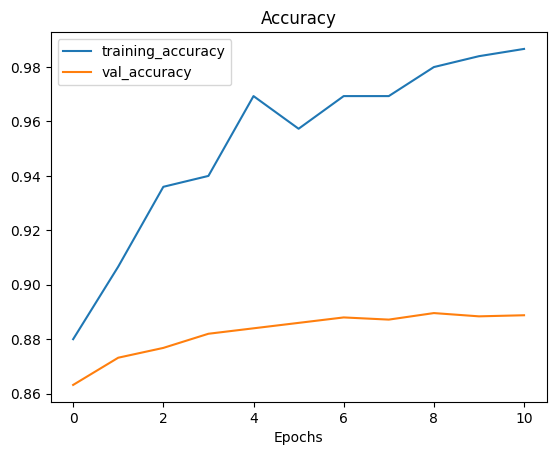

In [29]:
# Plot loss curve
plot_loss_curves(history_fine_10_percent_data)

In [30]:
# Let's create a function to compare training histories
def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two TensorFlow History objects. 
    """ 
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history metrics with new_history metrics
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]


    # Make plot for accuracy
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label="Training Accuracy")
    plt.plot(total_val_acc, label="Val Accuracy")
    plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start Fine Tuning", color="r") # Plotting the line where fine tuning started
    plt.legend(loc="lower right")
    plt.title("Training and Validation Accuracy")


    # Make plot for loss
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label="Training Loss")
    plt.plot(total_val_loss, label="Val Loss")
    plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start Fine Tuning", color="r") # Plotting the line where fine tuning started
    plt.legend(loc="upper right")
    plt.title("Training and Validation Loss")
        


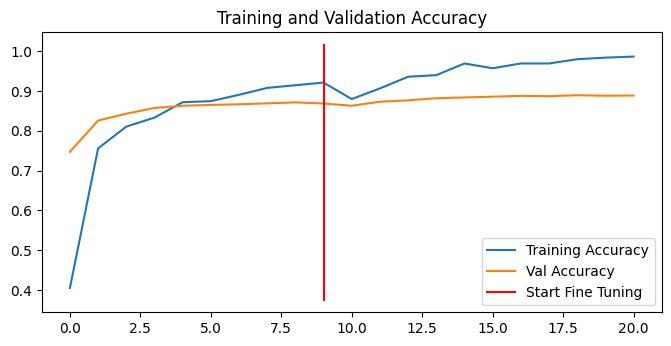

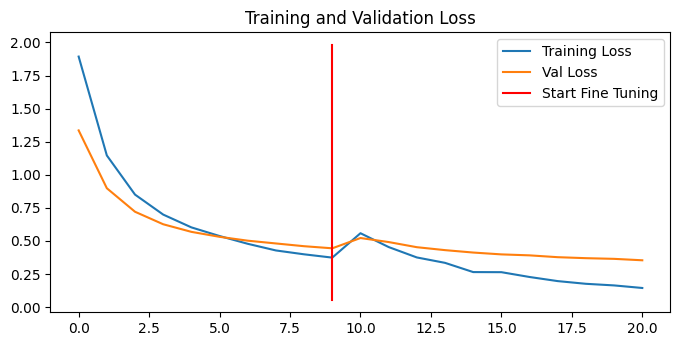

In [31]:
compare_historys(history_10_percent, history_fine_10_percent_data, initial_epochs=10)

### 3. Fine-tune the last 20 layers of the base model you trained in 2 for another 10 epochs. How did it go?

To train a fine-tuning model we need to revert model_0 back to its feature extraction weights.

In [32]:
# Load weights from checkpoint, that way we can fine-tune from 
# the same stage the 10 percent data model was fine-tuned from
model_0.load_weights(checkpoint_path)

/opt/anaconda3/envs/tensorflow_venv/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 58 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [33]:
# Check which layers are tunable in the whole model
for layer_number, layer in enumerate(model_0.layers):
    print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 efficientnetv2-b0 True
2 global_average_pooling_layer True
3 output_layer True


In [34]:
# Let's drill into our base_model (efficientnetb0) and see what layers are trainable
for layer_number, layer in enumerate(base_model.layers):
    print(layer_number, layer.name, layer.trainable)

0 input_layer False
1 rescaling False
2 normalization False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 

In [35]:
base_model

<Functional name=efficientnetv2-b0, built=True>

In [36]:
# Freeze all layers except for the last 30
base_model.trainable = True

for layer in base_model.layers[:-20]:
    layer.trainable = False

In [37]:
# Re-compiling model for fine tuning 
model_0.compile(loss = 'categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics = ['accuracy'])

In [38]:
# Let's drill into our base_model (efficientnetb0) and see what layers are trainable
for layer_number, layer in enumerate(base_model.layers):
    print(layer_number, layer.name, layer.trainable)

0 input_layer False
1 rescaling False
2 normalization False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 

In [39]:
# Now we've unfrozen some of the layers closer to the top, how many trainable variables are there?
print(len(model_0.trainable_variables))

18


In [40]:
# Fine tune for another 10 epochs
fine_tune_epochs = initial_epochs + 10

# Refit the model (same as model_2 except with more trainable layers)
history_fine_10_percent_data_20layers = model_0.fit(train_data_10_percent,
                                               epochs=fine_tune_epochs,
                                               validation_data=test_data,
                                               validation_steps=int(len(test_data)),
                                               initial_epoch=history_10_percent.epoch[-1], # start training from previous last epoch
                                                )

Epoch 10/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - accuracy: 0.9127 - loss: 0.4767 - val_accuracy: 0.8704 - val_loss: 0.5038
Epoch 11/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 13s 573ms/step - accuracy: 0.9366 - loss: 0.4174 - val_accuracy: 0.8772 - val_loss: 0.4750
Epoch 12/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 12s 532ms/step - accuracy: 0.9454 - loss: 0.3506 - val_accuracy: 0.8784 - val_loss: 0.4522
Epoch 13/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 12s 493ms/step - accuracy: 0.9521 - loss: 0.3135 - val_accuracy: 0.8804 - val_loss: 0.4337
Epoch 14/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 12s 493ms/step - accuracy: 0.9406 - loss: 0.3012 - val_accuracy: 0.8824 - val_loss: 0.4178
Epoch 15/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 12s 501ms/step - accuracy: 0.9744 - loss: 0.2578 - val_accuracy: 0.8860 - val_loss: 0.4008
Epoch 16/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 484ms/step - accuracy: 0.9715 - loss: 0.2162 - val_accuracy: 0.8884 - val_loss: 0.3924
Epoch 17/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 462ms/step - accuracy: 0.9653 - loss: 0.2267 - val

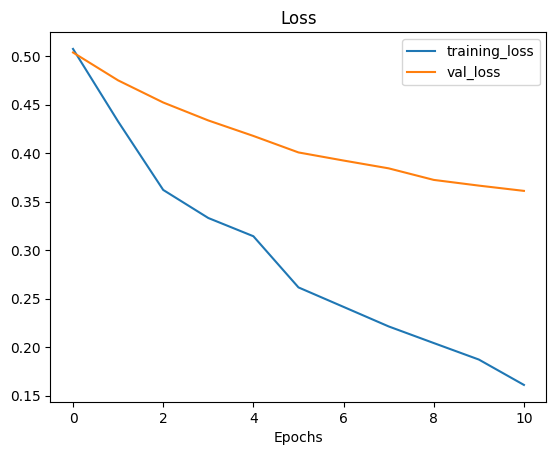

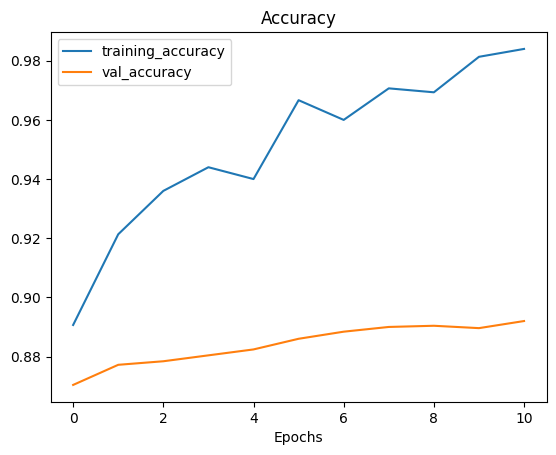

In [41]:
# Plot loss curve
plot_loss_curves(history_fine_10_percent_data_20layers)

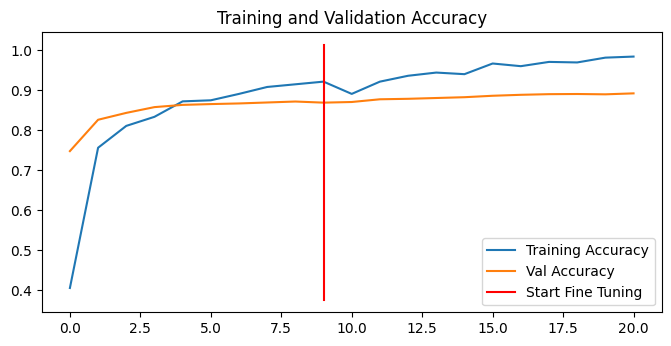

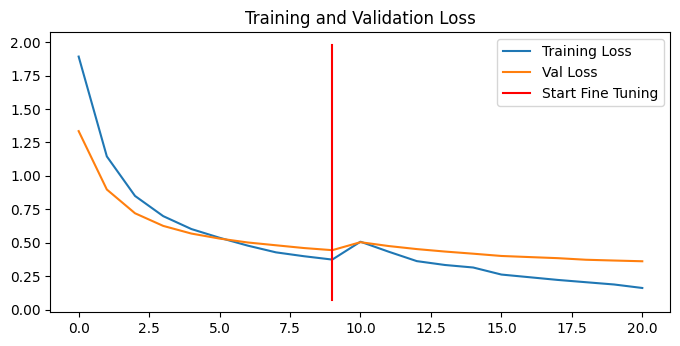

In [42]:
compare_historys(history_10_percent, history_fine_10_percent_data_20layers, initial_epochs=10)